[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_C.ipynb)

# 枝刈りによるモデルの性能低下の評価

## すべての全結合層を同じ割合で枝刈り

以下のセルは絶対値が小さいパラメータを枝刈りします。  
パラメータを50%以上枝刈りするあたりで精度が下がり始めます。

Epoch 1, Loss: 0.40478794425249354
Epoch 2, Loss: 0.190163238430773
Epoch 3, Loss: 0.13955546858837642
Epoch 4, Loss: 0.11244555505395715
Epoch 5, Loss: 0.09504990389536835
Accuracy before pruning: 96.71%
Parameters before pruning: Total = 109386, Non-zero = 109386
Pruning rate: 9.98%, Accuracy: 96.67%
Pruning rate: 19.96%, Accuracy: 96.65%
Pruning rate: 29.94%, Accuracy: 96.52%
Pruning rate: 39.92%, Accuracy: 96.36%
Pruning rate: 49.90%, Accuracy: 94.93%
Pruning rate: 59.89%, Accuracy: 93.92%
Pruning rate: 69.87%, Accuracy: 90.90%
Pruning rate: 79.85%, Accuracy: 74.20%
Pruning rate: 89.83%, Accuracy: 44.83%


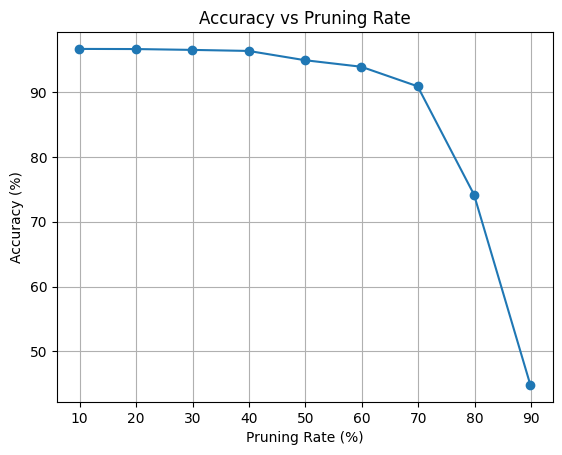

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# MNISTデータセットのロード
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('.', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# シンプルなモデルの定義
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 画像を1次元に変換
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# モデルのインスタンス作成
model = SimpleNN()

# 損失関数と最適化手法の設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練ループ
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  # 勾配の初期化
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # 勾配計算
        optimizer.step()  # パラメータ更新
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

# プルーニング前のモデルを評価
model.eval()
correct = 0
total = 0
testset = datasets.MNIST('.', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy before pruning: {100 * correct / total}%')

# プルーニング前後のパラメータ数を表示する関数
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    non_zero_params = sum(torch.count_nonzero(p).item() for p in model.parameters())
    return total_params, non_zero_params

# プルーニング前のパラメータ数
total_params, non_zero_params = count_parameters(model)
print(f"Parameters before pruning: Total = {total_params}, Non-zero = {non_zero_params}")

# プルーニング関数
def prune_model(model, pruning_percentage=0.2):
    """
    モデルの重みをプルーニング（小さい重みをゼロに置き換え）
    pruning_percentage: ゼロに置き換える重みの割合
    """
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:  # 重みパラメータのみ対象
                # 重みを小さい順に並べて、指定された割合の重みをゼロにする
                num_prune = int(param.numel() * pruning_percentage)
                flat_param = param.abs().flatten()
                threshold = torch.topk(flat_param, num_prune, largest=False).values[-1]
                param.data[torch.abs(param.data) < threshold] = 0

import copy
import matplotlib.pyplot as plt

# プルーニング後のモデルを評価する関数
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# プルーニング率と精度を保存するリスト
pruning_rates = []
accuracies = []

# 複数のプルーニング率でモデルを評価
for rate in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # モデルをクローンしてプルーニング
    pruned_model = copy.deepcopy(model)
    prune_model(pruned_model, pruning_percentage=rate)

    # プルーニング後のパラメータ数と精度を取得
    total_params, non_zero_params = count_parameters(pruned_model)
    pruning_rate = 100 * (1 - non_zero_params / total_params)
    accuracy = evaluate_model(pruned_model)

    # プルーニング率と精度をリストに追加
    pruning_rates.append(pruning_rate)
    accuracies.append(accuracy)

    print(f"Pruning rate: {pruning_rate:.2f}%, Accuracy: {accuracy:.2f}%")

# 結果をプロット
plt.plot(pruning_rates, accuracies, marker='o')
plt.xlabel('Pruning Rate (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Pruning Rate')
plt.grid(True)
plt.show()


## 最初の全結合層だけ枝刈り

``` Python
if 'fc1' in name:
```
によって最初の全結合層だけ選択できます。

Epoch 1, Loss: 0.3966596274773703
Epoch 2, Loss: 0.18633097009872324
Epoch 3, Loss: 0.13550210508730398
Epoch 4, Loss: 0.10812623192593931
Epoch 5, Loss: 0.09302997264141308
Accuracy before pruning: 96.91%
Parameters before pruning: Total = 109386, Non-zero = 109386
Pruning rate: 9.17%, Accuracy: 96.93%
Pruning rate: 18.35%, Accuracy: 96.92%
Pruning rate: 27.52%, Accuracy: 96.97%
Pruning rate: 36.69%, Accuracy: 96.93%
Pruning rate: 45.87%, Accuracy: 96.91%
Pruning rate: 55.04%, Accuracy: 96.41%
Pruning rate: 64.22%, Accuracy: 94.88%
Pruning rate: 73.39%, Accuracy: 86.59%
Pruning rate: 82.57%, Accuracy: 68.20%


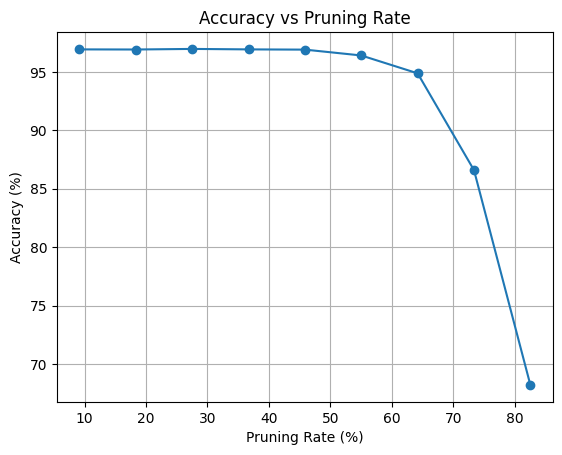

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# MNISTデータセットのロード
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('.', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# シンプルなモデルの定義
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 画像を1次元に変換
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# モデルのインスタンス作成
model = SimpleNN()

# 損失関数と最適化手法の設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練ループ
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  # 勾配の初期化
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # 勾配計算
        optimizer.step()  # パラメータ更新
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

# プルーニング前のモデルを評価
model.eval()
correct = 0
total = 0
testset = datasets.MNIST('.', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy before pruning: {100 * correct / total}%')

# プルーニング前後のパラメータ数を表示する関数
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    non_zero_params = sum(torch.count_nonzero(p).item() for p in model.parameters())
    return total_params, non_zero_params

# プルーニング前のパラメータ数
total_params, non_zero_params = count_parameters(model)
print(f"Parameters before pruning: Total = {total_params}, Non-zero = {non_zero_params}")

# プルーニング関数
def prune_model(model, pruning_percentage=0.2):
    """
    モデルの重みをプルーニング（小さい重みをゼロに置き換え）
    pruning_percentage: ゼロに置き換える重みの割合
    """
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:  # 重みパラメータのみ対象
                # 最初の層だけpruning
                if 'fc1' in name:
                    layer_pruning_percentage = pruning_percentage  # 最初の層
                else:
                    layer_pruning_percentage = 0  # 最初の層以外
                num_prune = int(param.numel() * layer_pruning_percentage)
                flat_param = param.abs().flatten()
                if num_prune > 0:
                    threshold = torch.topk(flat_param, num_prune, largest=False).values[-1]
                    param.data[torch.abs(param.data) < threshold] = 0

import copy
import matplotlib.pyplot as plt

# プルーニング後のモデルを評価する関数
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# プルーニング率と精度を保存するリスト
pruning_rates = []
accuracies = []

# 複数のプルーニング率でモデルを評価
for rate in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # モデルをクローンしてプルーニング
    pruned_model = copy.deepcopy(model)
    prune_model(pruned_model, pruning_percentage=rate)

    # プルーニング後のパラメータ数と精度を取得
    total_params, non_zero_params = count_parameters(pruned_model)
    pruning_rate = 100 * (1 - non_zero_params / total_params)
    accuracy = evaluate_model(pruned_model)

    # プルーニング率と精度をリストに追加
    pruning_rates.append(pruning_rate)
    accuracies.append(accuracy)

    print(f"Pruning rate: {pruning_rate:.2f}%, Accuracy: {accuracy:.2f}%")

# 結果をプロット
plt.plot(pruning_rates, accuracies, marker='o')
plt.xlabel('Pruning Rate (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Pruning Rate')
plt.grid(True)
plt.show()


以下のセルによって、最初の全結合層の重みが28$\times$28の画像とどのように乗算されるか考察できます。

torch.Size([128, 784])


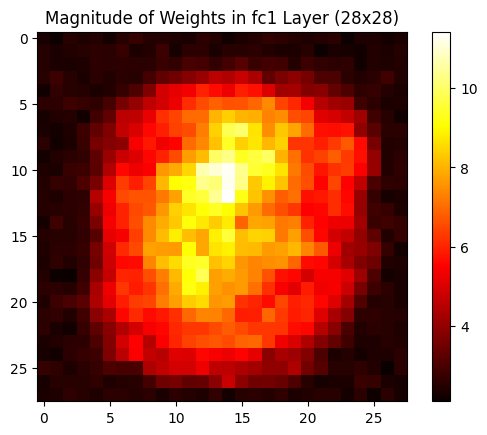

In [11]:
import torch
import matplotlib.pyplot as plt

# fc1層の重みを取得
fc1_weights = model.fc1.weight
print(fc1_weights.shape)

# 各入力ユニット（784次元）の重みの絶対値の和を計算
input_magnitudes = torch.sum(torch.abs(fc1_weights), dim=0)

# 絶対値の和を28x28の画像にリシェイプ
input_magnitudes_2d = input_magnitudes.view(28, 28).detach().numpy()

# 結果をプロット
plt.imshow(input_magnitudes_2d, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Magnitude of Weights in fc1 Layer (28x28)')
plt.show()
